## Prerequisites

1. Import Libraries 
2. Drive Mounting
3. Setting Working Directory
4. Saving Paths in Variables
5. Assigning Labels to Classes.


In [ ]:
# Importing Libraries

import numpy as np
import pandas as pd
from PIL import Image
import os
import glob
import cv2
import random
import shutil
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import gc
import time
import tqdm.notebook as tq
from google.colab import output
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras import optimizers, Model, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.inception_v3 import InceptionV3

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Mounting Google Drive

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Changing working directory

%cd /content/drive/My Drive/Colab Notebooks/Traffic Sign/KaggleData

/content/drive/My Drive/Colab Notebooks/Traffic Sign/KaggleData


In [ ]:
# Paths and parameters.

numpyarray_path = '../NumpyArrays'
train_data_path = '../NumpyArrays/Cells.npy'
train_label_path = '../NumpyArrays/Labels.npy'
test_data_path = '../NumpyArrays/Cells_test.npy'
test_blur3_path = '../NumpyArrays/Cells_test_blur3.npy'
test_blur5_path = '../NumpyArrays/Cells_test_blur5.npy'
test_blur7_path = '../NumpyArrays/Cells_test_blur7.npy'
test_label_path = '../NumpyArrays/Labels_test.npy'
visualization_path = '../Visualizations'
train_folders_path = '../Dataset/Train/{}'

height = 75
width = 75
channels = 3
classes = 43
n_inputs = height*width*channels


### Labels for Traffic Class



In [ ]:
traffic_class_labels = {0: '20 km/h',
1:'30 km/h',
2:'50 km/h',
3:'60 km/h',
4:'70 km/h',
5:'80 km/h',
6:'80 km/h end',
7:'100 km/h',
8:'120 km/h',
9:'No overtaking',
10:'No overtaking for trucks',
11:'Crossroad with secondary way',
12:'Main road',
13:'Give way',
14:'Stop',
15:'Road up',
16:'Road up for trucks',
17:'No Entry',
18:'Other dangerous',
19:'Turn left',
20:'Turn right',
21:'Winding road',
22:'Hollow road',
23:'Slippery road',
24:'Narrowing road',
25:'Roadwork',
26:'Traffic light',
27:'Pedestrian',
28:'Children',
29:'Cycle',
30:'Snow',
31:'Deer',
32:'End of the limits',
33:'Only right',
34:'Only left',
35:'Only straight',
36:'Only straight and right',
37:'Only straight and left',
38:'Take right',
39:'Take left',
40:'Circle crossroad',
41:'End of overtaking limit',
42:'End of overtaking limit for track'
}

traffic_class_list = ["Class00", "Class01", "Class02", "Class03", "Class04", "Class05", "Class06", "Class07", "Class08", "Class09", 
 "Class10", "Class11", "Class12", "Class13", "Class14", "Class15", "Class16", "Class17", "Class18", "Class19", 
 "Class20", "Class21", "Class22", "Class23", "Class24", "Class25", "Class26", "Class27", "Class28", "Class29", 
 "Class30", "Class31", "Class32", "Class33", "Class34", "Class35", "Class36", "Class37", "Class38", "Class39", 
 "Class40", "Class41", "Class42"]


In [ ]:
traffic_class_labels_series = pd.Series(traffic_class_labels)
traffic_class_labels_series.head()

0    20 km/h
1    30 km/h
2    50 km/h
3    60 km/h
4    70 km/h
dtype: object

In [ ]:
traffic_class_series = pd.Series(traffic_class_list)
traffic_class_series.head()

0    Class00
1    Class01
2    Class02
3    Class03
4    Class04
dtype: object

In [ ]:
traffic_sign_labels_df = pd.concat([traffic_class_labels_series, 
                                    traffic_class_series], 
                                   axis=1)
traffic_sign_labels_df.reset_index(inplace=True)
traffic_sign_labels_df.rename(columns = {0:'Original_Class_Names', 
                                         1: 'New_Class_Names',
                                         'index': 'Class_Name_Index'}, 
                              inplace = True)

traffic_sign_labels_df.head()

,Class_Name_Index,Original_Class_Names,New_Class_Names
0,0,20 km/h,Class00
1,1,30 km/h,Class01
2,2,50 km/h,Class02
3,3,60 km/h,Class03
4,4,70 km/h,Class04


In [ ]:
labels_dict = traffic_sign_labels_df['New_Class_Names'].to_dict()
labels_dict

{0: 'Class00',
 1: 'Class01',
 2: 'Class02',
 3: 'Class03',
 4: 'Class04',
 5: 'Class05',
 6: 'Class06',
 7: 'Class07',
 8: 'Class08',
 9: 'Class09',
 10: 'Class10',
 11: 'Class11',
 12: 'Class12',
 13: 'Class13',
 14: 'Class14',
 15: 'Class15',
 16: 'Class16',
 17: 'Class17',
 18: 'Class18',
 19: 'Class19',
 20: 'Class20',
 21: 'Class21',
 22: 'Class22',
 23: 'Class23',
 24: 'Class24',
 25: 'Class25',
 26: 'Class26',
 27: 'Class27',
 28: 'Class28',
 29: 'Class29',
 30: 'Class30',
 31: 'Class31',
 32: 'Class32',
 33: 'Class33',
 34: 'Class34',
 35: 'Class35',
 36: 'Class36',
 37: 'Class37',
 38: 'Class38',
 39: 'Class39',
 40: 'Class40',
 41: 'Class41',
 42: 'Class42'}

In [ ]:
class_labels = [traffic_class_labels[i] for i in range(len(traffic_class_labels))]
class_labels

['20 km/h',
 '30 km/h',
 '50 km/h',
 '60 km/h',
 '70 km/h',
 '80 km/h',
 '80 km/h end',
 '100 km/h',
 '120 km/h',
 'No overtaking',
 'No overtaking for trucks',
 'Crossroad with secondary way',
 'Main road',
 'Give way',
 'Stop',
 'Road up',
 'Road up for trucks',
 'No Entry',
 'Other dangerous',
 'Turn left',
 'Turn right',
 'Winding road',
 'Hollow road',
 'Slippery road',
 'Narrowing road',
 'Roadwork',
 'Traffic light',
 'Pedestrian',
 'Children',
 'Cycle',
 'Snow',
 'Deer',
 'End of the limits',
 'Only right',
 'Only left',
 'Only straight',
 'Only straight and right',
 'Only straight and left',
 'Take right',
 'Take left',
 'Circle crossroad',
 'End of overtaking limit',
 'End of overtaking limit for track']

## Data Preprocessing and Transformation

### Exploratory Data Analysis

In [ ]:
# Created a dataframe that has number of images per class in train dataset.

files_count = pd.DataFrame(columns=['Class', 'Count'])

for i in range(classes):
    class_name = 'Class0{}'.format(i) if i<=9 else 'Class{}'.format(i)
    class_count = len(os.listdir(train_folders_path.format(i)))
    tempdf = pd.DataFrame([[class_name, class_count]], columns=['Class', 'Count'])
    files_count = files_count.append(tempdf)

del tempdf
files_count.head()

,Class,Count
0,Class00,210
0,Class01,2220
0,Class02,2250
0,Class03,1410
0,Class04,1980


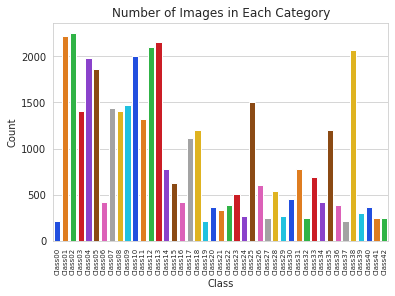

In [ ]:
# Plot of number of images in each class.

sns.set_style('whitegrid')
sns.barplot(files_count['Class'], files_count['Count'], palette='bright')
plt.title('Number of Images in Each Category')
plt.xticks(rotation=90)
plt.tick_params(axis='x', which='major', labelsize=7)

plt.savefig(os.path.join(visualization_path, 'images_per_category.png'), dpi=300, bbox_inches='tight')

### Copying data from Kaggle

In [ ]:
# Providing config path of kaggle.json file

os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Colab Notebooks/Traffic Sign/KaggleData"

In [ ]:
# Fetching data from kaggle to Google Drive.

!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

 98% 601M/612M [00:18<00:00, 46.5MB/s]
100% 612M/612M [00:18<00:00, 35.3MB/s]


### Unzipping Kaggle data to Dataset folder.


In [ ]:
# Checking and removing the files present in Dataset folder before unzipping the new files.
# Take almost 11 mins.

# Uncomment the below code (Commented to avoid deleting files by mistake)

%%time

# while(os.path.isdir('../Dataset')):
#   shutil.rmtree('../Dataset/', ignore_errors=True)

CPU times: user 1.26 s, sys: 1.17 s, total: 2.43 s
Wall time: 1min 32s


In [ ]:
# Unzipping kaggle files.
# Take almost 26 mins.

# Uncomment the below code (Commented to avoid unzipping files by mistake)

%%time
# !unzip '/content/drive/My Drive/Colab Notebooks/Traffic Sign/KaggleData/gtsrb-german-traffic-sign.zip' -d '/content/drive/My Drive/Colab Notebooks/Traffic Sign/Dataset'


Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/My Drive/Colab Notebooks/Traffic Sign/Dataset/train/34/00034_00010_00007.png  
  inflating: /content/drive/My Drive/Colab Notebooks/Traffic Sign/Dataset/train/34/00034_00010_00008.png  
  inflating: /content/drive/My Drive/Colab Notebooks/Traffic Sign/Dataset/train/34/00034_00010_00009.png  
  inflating: /content/drive/My Drive/Colab Notebooks/Traffic Sign/Dataset/train/34/00034_00010_00010.png  
  inflating: /content/drive/My Drive/Colab Notebooks/Traffic Sign/Dataset/train/34/00034_00010_00011.png  
  inflating: /content/drive/My Drive/Colab Notebooks/Traffic Sign/Dataset/train/34/00034_00010_00012.png  
  inflating: /content/drive/My Drive/Colab Notebooks/Traffic Sign/Dataset/train/34/00034_00010_00013.png  
  inflating: /content/drive/My Drive/Colab Notebooks/Traffic Sign/Dataset/train/34/00034_00010_00014.png  
  inflating: /content/drive/My Drive/Colab Notebooks/Traffic Sign/Dataset/train/34/00034_0001

### Train and Test Images are read, converted into array and saved arrays as .npy file.


In [ ]:
# Reading the input images and putting them into a numpy array

cells=[]
labels=[]

for i in range(classes):
    path = "../Dataset/Train/{0}/".format(i)
    print(path)
    Class=os.listdir(path)
    bar = tq.tqdm(range(len(Class)))
    for j in bar:
        try:
            image=cv2.imread(path+Class[j])
            image_from_array = Image.fromarray(image, 'RGB')
            size_image = image_from_array.resize((height, width))
            cells.append(np.array(size_image))
            labels.append(i)
        except AttributeError:
            print(" ")
    if i!=classes-1:
      output.clear() 

../Dataset/Train/42/


Length of cells List:  39209
Length of labels List:  39209

1


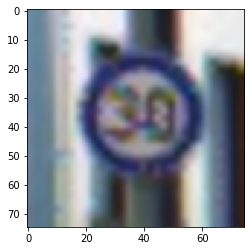

In [ ]:
# Displayed a random image to verify that it's read properly.

print('Length of cells List: ',len(cells))
print('Length of labels List: ',len(labels))
print('')
print(labels[1020])
plt.imshow(cells[1020])

1


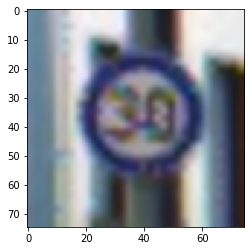

In [ ]:
# Lists are converted to numpy arrays and verified that it's read properly by displaying a random image.

Cells=np.array(cells)
Labels=np.array(labels)

print(Labels[1020])
plt.imshow(Cells[1020])

In [ ]:
# If directory is not present, a new one is created. Arrays are saved in the directory

if not os.path.isdir(numpyarray_path): 
  os.mkdir(numpyarray_path)

np.save(train_data_path, Cells)
np.save(train_label_path, Labels)

In [ ]:
# Clearing memory.

del cells
del Cells
del labels
del Labels

gc.collect()

673

In [ ]:
pd.read_csv("../Dataset/Test.csv").head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [ ]:
# Loading test data.

y_test=pd.read_csv("../Dataset/Test.csv")
paths=y_test['Path']

cells=[]
labels=y_test['ClassId'].values

for f in tq.tqdm(range(len(paths))):
    # print(paths[f])
    image=cv2.imread('../Dataset/'+paths[f])
    image_from_array = Image.fromarray(image, 'RGB')
    size_image = image_from_array.resize((height, width))
    cells.append(np.array(size_image))


Length of cells List:  12630
Length of labels List:  12630

35


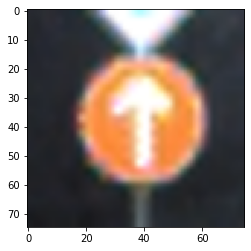

In [ ]:
# A random test image is displayed.

print('Length of cells List: ',len(cells))
print('Length of labels List: ',len(labels))
print('')
print(labels[1100])
plt.imshow(cells[1100])

35


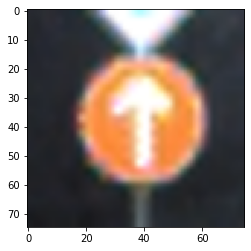

In [ ]:
# Converting lists into numpy arrays and verifying by printing a random image.

Cells=np.array(cells)
Labels=np.array(labels)

print(Labels[1100])
plt.imshow(Cells[1100])

In [ ]:
# Saving test data array to files.

np.save(test_data_path, Cells)
np.save(test_label_path, Labels)

In [ ]:
# Clearing memory.

del cells
del Cells
del labels
del Labels
del y_test
del paths

gc.collect()

284

### Test images are blurred in three levels and saved in numpy arrays.

In [ ]:
# Read test images, blured them at 3X3, 5X5, and 7X7 levels.
# Appended the images to the respective lists.

y_test=pd.read_csv("../Dataset/Test.csv")
paths=y_test['Path']

cells_3 = []
cells_5 = []
cells_7 = []
labels=y_test['ClassId'].values

for f in tq.tqdm(range(len(paths))):
    # print(paths[f])
    image=cv2.imread('../Dataset/'+paths[f])

    blurred_image_3 = cv2.GaussianBlur(image, (3,3), cv2.BORDER_DEFAULT)
    image_from_array_3 = Image.fromarray(blurred_image_3, 'RGB')
    resize_image_3 = image_from_array_3.resize((height, width))
    cells_3.append(np.array(resize_image_3))

    blurred_image_5 = cv2.GaussianBlur(image, (5,5), cv2.BORDER_DEFAULT)
    image_from_array_5 = Image.fromarray(blurred_image_5, 'RGB')
    resize_image_5 = image_from_array_5.resize((height, width))
    cells_5.append(np.array(resize_image_5))

    blurred_image_7 = cv2.GaussianBlur(image, (7,7), cv2.BORDER_DEFAULT)
    image_from_array_7 = Image.fromarray(blurred_image_7, 'RGB')
    resize_image_7 = image_from_array_7.resize((height, width))
    cells_7.append(np.array(resize_image_7))

In [ ]:
# Converting test data to arrays.

Cells_3 = np.array(cells_3)
Cells_5 = np.array(cells_5)
Cells_7 = np.array(cells_7)

1


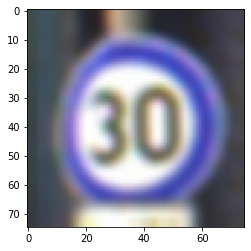

In [ ]:
# Blur level 3.

print(labels[1])
plt.imshow(Cells_3[1])

1


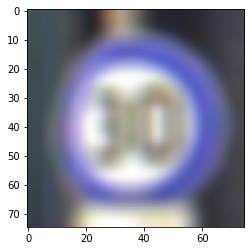

In [ ]:
# Blur level 5.

print(labels[1])
plt.imshow(Cells_5[1])

1


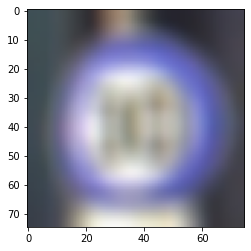

In [ ]:
# Blur level 7.

print(labels[1])
plt.imshow(Cells_7[1])

In [ ]:
# Saving test data array to files.

np.save(test_blur3_path, Cells_3)
np.save(test_blur5_path, Cells_5)
np.save(test_blur7_path, Cells_7)

In [ ]:
# Clearing memory.

del labels
del cells_3
del cells_5
del cells_7
del Cells_3
del Cells_5
del Cells_7
del paths
del y_test

gc.collect()

## Read Numpy arrays from saved files and divided in Train, Validation, and Test sets.


In [ ]:
# A new starting point to the process.
# Loading Train Data.

Cells = np.load(train_data_path)
labels = np.load(train_label_path)

In [ ]:
# Randomize the order of the input images

s=np.arange(Cells.shape[0])
np.random.seed(43)
np.random.shuffle(s)
Cells=Cells[s]
labels=labels[s]

In [ ]:
# Spliting the images into train and validation sets

(X_train,X_val)=Cells[(int)(0.2*len(labels)):],Cells[:(int)(0.2*len(labels))]

X_train = X_train.astype('float32')/255 
X_val = X_val.astype('float32')/255

(y_train,y_val)=labels[(int)(0.2*len(labels)):],labels[:(int)(0.2*len(labels))]

In [ ]:
# Using one hote encoding for the train and validation labels

y_train = to_categorical(y_train, classes)
y_val = to_categorical(y_val, classes)

In [ ]:
# Loading test data from saved array files.

X_test = np.load(test_data_path)
X_test_3 = np.load(test_blur3_path)
X_test_5 = np.load(test_blur5_path)
X_test_7 = np.load(test_blur7_path)
y_test = np.load(test_label_path)

1


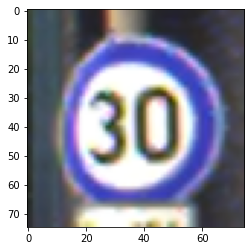

In [ ]:
# Original Image.

print(y_test[1])
plt.imshow(X_test[1])

1


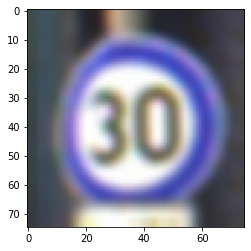

In [ ]:
# Image blurred at level 3.

print(y_test[1])
plt.imshow(X_test_3[1])

1


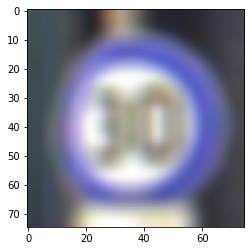

In [ ]:
# Image blurred at level 5.

print(y_test[1])
plt.imshow(X_test_5[1])

1


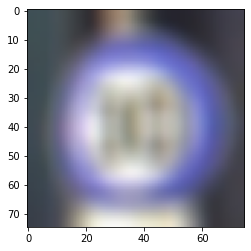

In [ ]:
# Image blurred at level 7.

print(y_test[1])
plt.imshow(X_test_7[1])

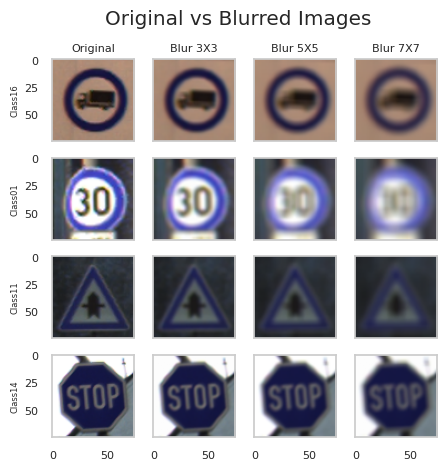

In [ ]:
# Collage of Original vs Blurred images of various classes.

fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(5, 5), dpi=100)

fig.suptitle("Original vs Blurred Images", fontdict = {'fontsize': 10, 'fontweight' : 3})

ax[0,0].set_title("Original", fontdict = {'fontsize': 8, 'fontweight' : 3})
ax[0,0].imshow(X_test[0])
ax[0,0].get_xaxis().set_visible(False)
ax[0,0].set_ylabel(traffic_class_list[y_test[0]], fontdict = {'fontsize': 6, 'fontweight' : 3})
ax[0,0].grid(False)
ax[0,0].tick_params(axis='both', which='major', labelsize=8)

ax[0,1].set_title("Blur 3X3", fontdict = {'fontsize': 8, 'fontweight' : 3})
ax[0,1].imshow(X_test_3[0])
ax[0,1].get_yaxis().set_visible(False)
ax[0,1].get_xaxis().set_visible(False)
ax[0,1].grid(False)

ax[0,2].set_title("Blur 5X5", fontdict = {'fontsize': 8, 'fontweight' : 3})
ax[0,2].imshow(X_test_5[0])
ax[0,2].get_yaxis().set_visible(False)
ax[0,2].get_xaxis().set_visible(False)
ax[0,2].grid(False)

ax[0,3].set_title("Blur 7X7", fontdict = {'fontsize': 8, 'fontweight' : 3})
ax[0,3].imshow(X_test_7[0])
ax[0,3].get_yaxis().set_visible(False)
ax[0,3].get_xaxis().set_visible(False)
ax[0,3].grid(False)

ax[1,0].imshow(X_test[1])
ax[1,0].get_xaxis().set_visible(False)
ax[1,0].set_ylabel(traffic_class_list[y_test[1]], fontdict = {'fontsize': 6, 'fontweight' : 3})
ax[1,0].grid(False)  
ax[1,0].tick_params(axis='both', which='major', labelsize=8)

ax[1,1].imshow(X_test_3[1])
ax[1,1].get_yaxis().set_visible(False)
ax[1,1].get_xaxis().set_visible(False)
ax[1,1].grid(False)   

ax[1,2].imshow(X_test_5[1])
ax[1,2].get_yaxis().set_visible(False)
ax[1,2].get_xaxis().set_visible(False)
ax[1,2].grid(False)   

ax[1,3].imshow(X_test_7[1])
ax[1,3].get_yaxis().set_visible(False)
ax[1,3].get_xaxis().set_visible(False)
ax[1,3].grid(False)

ax[2,0].imshow(X_test[4])
ax[2,0].get_xaxis().set_visible(False)
ax[2,0].set_ylabel(traffic_class_list[y_test[4]], fontdict = {'fontsize': 6, 'fontweight' : 3})
ax[2,0].grid(False)   
ax[2,0].tick_params(axis='both', which='major', labelsize=8)

ax[2,1].imshow(X_test_3[4])
ax[2,1].get_yaxis().set_visible(False)
ax[2,1].get_xaxis().set_visible(False)
ax[2,1].grid(False)

ax[2,2].imshow(X_test_5[4])
ax[2,2].get_yaxis().set_visible(False)
ax[2,2].get_xaxis().set_visible(False)
ax[2,2].grid(False)   

ax[2,3].imshow(X_test_7[4])
ax[2,3].get_yaxis().set_visible(False)
ax[2,3].get_xaxis().set_visible(False)
ax[2,3].grid(False)

ax[3,0].imshow(X_test[93])
ax[3,0].set_ylabel(traffic_class_list[y_test[93]], fontdict = {'fontsize': 6, 'fontweight' : 3})
ax[3,0].grid(False)  
ax[3,0].tick_params(axis='both', which='major', labelsize=8) 

ax[3,1].imshow(X_test_3[93])
ax[3,1].get_yaxis().set_visible(False)
ax[3,1].grid(False)   
ax[3,1].tick_params(axis='both', which='major', labelsize=8)

ax[3,2].imshow(X_test_5[93])
ax[3,2].get_yaxis().set_visible(False)
ax[3,2].grid(False)   
ax[3,2].tick_params(axis='both', which='major', labelsize=8)

ax[3,3].imshow(X_test_7[93])
ax[3,3].get_yaxis().set_visible(False)
ax[3,3].grid(False)
ax[3,3].tick_params(axis='both', which='major', labelsize=8)


fig.savefig(os.path.join(visualization_path, 'original_vs_blurred.png'), dpi=300, bbox_inches='tight')

In [ ]:
# Dividing images by 255 to convert the range of 0-255 to 0.0-1.0

X_test = X_test.astype('float32')/255 
X_test_3 = X_test_3.astype('float32')/255 
X_test_5 = X_test_5.astype('float32')/255 
X_test_7 = X_test_7.astype('float32')/255 

## Self-designed CNN model

In [ ]:
# Definition of the CNN model

self_model = Sequential()
self_model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', 
                      input_shape=X_train.shape[1:]))
self_model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
self_model.add(MaxPool2D(pool_size=(2, 2)))
self_model.add(Dropout(rate=0.25))
self_model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
self_model.add(MaxPool2D(pool_size=(2, 2)))
self_model.add(Dropout(rate=0.25))
self_model.add(Flatten())
self_model.add(Dense(256, activation='relu'))
self_model.add(Dropout(rate=0.5))
self_model.add(Dense(43, activation='softmax'))

In [ ]:
# Compiling the model

self_model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)

In [ ]:
# Fitting model with 20 epochs

self_epochs = 20
self_batch_size = 32

start_time = time.time()

self_history = self_model.fit(X_train, y_train, batch_size=self_batch_size, epochs=self_epochs,
validation_data=(X_val, y_val))

self_training_time = time.time()-start_time

Epoch 1/20
981/981 [==============================] - 18s 18ms/step - loss: 0.9481 - accuracy: 0.7332 - val_loss: 0.1120 - val_accuracy: 0.9754
Epoch 2/20
981/981 [==============================] - 18s 18ms/step - loss: 0.1775 - accuracy: 0.9470 - val_loss: 0.0679 - val_accuracy: 0.9843
Epoch 3/20
981/981 [==============================] - 18s 18ms/step - loss: 0.1196 - accuracy: 0.9626 - val_loss: 0.0564 - val_accuracy: 0.9864
Epoch 4/20
981/981 [==============================] - 18s 18ms/step - loss: 0.0900 - accuracy: 0.9716 - val_loss: 0.0409 - val_accuracy: 0.9913
Epoch 5/20
981/981 [==============================] - 18s 18ms/step - loss: 0.0798 - accuracy: 0.9754 - val_loss: 0.0387 - val_accuracy: 0.9918
Epoch 6/20
981/981 [==============================] - 18s 18ms/step - loss: 0.0805 - accuracy: 0.9761 - val_loss: 0.0347 - val_accuracy: 0.9926
Epoch 7/20
981/981 [==============================] - 18s 18ms/step - loss: 0.0600 - accuracy: 0.9811 - val_loss: 0.0366 - val_accuracy:

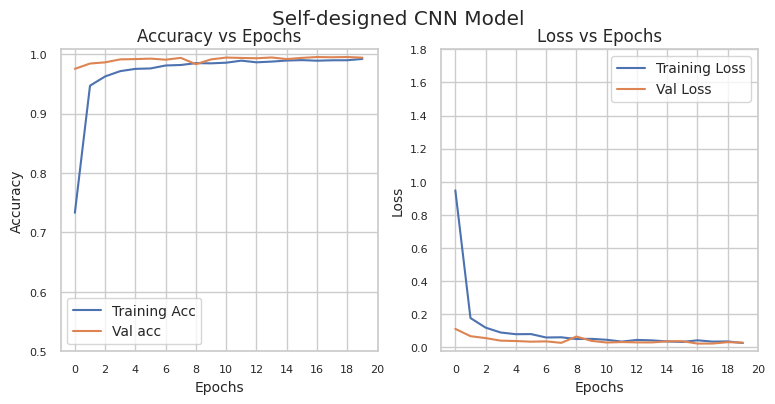

In [ ]:
# Plots of Accuracy and Loss vs Epochs.

sns.set_style('whitegrid')
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 4), dpi=100)


fig.suptitle("Self-designed CNN Model", fontdict = {'fontsize': 10, 'fontweight' : 3})

ax[0].set_title('Accuracy vs Epochs')
ax[0].plot(self_history.history['accuracy'], label='Training Acc')
ax[0].plot(self_history.history['val_accuracy'], label='Val acc')
ax[0].set_xlabel('Epochs', fontsize=10)
ax[0].set_ylabel('Accuracy', fontsize=10)
ax[0].legend(fontsize=10)
ax[0].tick_params(axis='both', which='major', labelsize=8)
ax[0].xaxis.set_ticks(np.arange(0, 21, 2))
ax[0].yaxis.set_ticks(np.arange(0.5, 1.05, 0.1))

ax[1].set_title('Loss vs Epochs')
ax[1].plot(self_history.history['loss'], label='Training Loss')
ax[1].plot(self_history.history['val_loss'], label='Val Loss')
ax[1].set_xlabel('Epochs', fontsize=10)
ax[1].set_ylabel('Loss', fontsize=10)
ax[1].legend(fontsize=10)
ax[1].tick_params(axis='both', which='major', labelsize=8)
ax[1].xaxis.set_ticks(np.arange(0, 21, 2))
ax[1].yaxis.set_ticks(np.arange(0, 1.9, 0.2))

fig.savefig(os.path.join(visualization_path, 'self_acc_loss.png'), dpi=300, bbox_inches='tight')

In [ ]:
# Predicting output using original and blurred test images.

self_pred = self_model.predict_classes(X_test)
self_pred_3 = self_model.predict_classes(X_test_3)
self_pred_5 = self_model.predict_classes(X_test_5)
self_pred_7 = self_model.predict_classes(X_test_7)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [ ]:
# Prediction accuracy of Original Images.

self_acc_original = accuracy_score(y_test, self_pred)
self_acc_original

0.9771179730799683

In [ ]:
# Prediction accuracy with images blurred at level 3.

self_acc_3 = accuracy_score(y_test, self_pred_3)
self_acc_3

0.9438638163103721

In [ ]:
# Prediction accuracy with images blurred at level 5.

self_acc_5 = accuracy_score(y_test, self_pred_5)
self_acc_5

0.7821060965954078

In [ ]:
# Prediction accuracy with images blurred at level 7.

self_acc_7 = accuracy_score(y_test, self_pred_7)
self_acc_7

0.6362628661916073

### Classification Reports

In [ ]:
# Classification report of Original images test data.

self_class_report = classification_report(y_test, self_pred, target_names = traffic_class_list, output_dict=True)
print(pd.DataFrame(self_class_report))

             Class00     Class01  ...     macro avg  weighted avg
precision   0.983051    0.990210  ...      0.975253      0.977548
recall      0.966667    0.983333  ...      0.969229      0.977118
f1-score    0.974790    0.986760  ...      0.971539      0.976957
support    60.000000  720.000000  ...  12630.000000  12630.000000

[4 rows x 46 columns]


In [ ]:
# Classification report of 3x3 images test data.

self_class_report_3 = classification_report(y_test, self_pred_3, target_names = traffic_class_list, output_dict=True)
print(pd.DataFrame(self_class_report_3))

             Class00     Class01  ...     macro avg  weighted avg
precision   0.950820    0.966325  ...      0.940698      0.947302
recall      0.966667    0.916667  ...      0.940575      0.943864
f1-score    0.958678    0.940841  ...      0.937608      0.944344
support    60.000000  720.000000  ...  12630.000000  12630.000000

[4 rows x 46 columns]


In [ ]:
# Classification report of 5x5 images test data.

self_class_report_5 = classification_report(y_test, self_pred_5, target_names = traffic_class_list, output_dict=True)
print(pd.DataFrame(self_class_report_5))

             Class00     Class01  ...     macro avg  weighted avg
precision   1.000000    0.851711  ...      0.830734      0.839386
recall      0.350000    0.622222  ...      0.779884      0.782106
f1-score    0.518519    0.719101  ...      0.779097      0.794657
support    60.000000  720.000000  ...  12630.000000  12630.000000

[4 rows x 46 columns]


In [ ]:
# Classification report of 7x7 images test data.

self_class_report_7 = classification_report(y_test, self_pred_7, target_names = traffic_class_list, output_dict=True)
print(pd.DataFrame(self_class_report_7))

             Class00     Class01  ...     macro avg  weighted avg
precision   0.900000    0.750000  ...      0.745467      0.749058
recall      0.150000    0.387500  ...      0.637074      0.636263
f1-score    0.257143    0.510989  ...      0.638892      0.654355
support    60.000000  720.000000  ...  12630.000000  12630.000000

[4 rows x 46 columns]


### Visualizations of Top and Bottom 5 classes.

In [ ]:
self_df_top = pd.DataFrame(self_class_report).transpose().sort_values(by='f1-score', ascending=False)[:5]
self_df_top.reset_index(inplace=True)
self_df_bottom = pd.DataFrame(self_class_report).transpose().sort_values(by='f1-score', ascending=True)[:5]
self_df_bottom.reset_index(inplace=True)

self_df_top_3 = pd.DataFrame(self_class_report_3).transpose().sort_values(by='f1-score', ascending=False)[:5]
self_df_top_3.reset_index(inplace=True)
self_df_bottom_3 = pd.DataFrame(self_class_report_3).transpose().sort_values(by='f1-score', ascending=True)[:5]
self_df_bottom_3.reset_index(inplace=True)

self_df_top_5 = pd.DataFrame(self_class_report_5).transpose().sort_values(by='f1-score', ascending=False)[:5]
self_df_top_5.reset_index(inplace=True)
self_df_bottom_5 = pd.DataFrame(self_class_report_5).transpose().sort_values(by='f1-score', ascending=True)[:5]
self_df_bottom_5.reset_index(inplace=True)

self_df_top_7 = pd.DataFrame(self_class_report_7).transpose().sort_values(by='f1-score', ascending=False)[:5]
self_df_top_7.reset_index(inplace=True)
self_df_bottom_7 = pd.DataFrame(self_class_report_7).transpose().sort_values(by='f1-score', ascending=True)[:5]
self_df_bottom_7.reset_index(inplace=True)

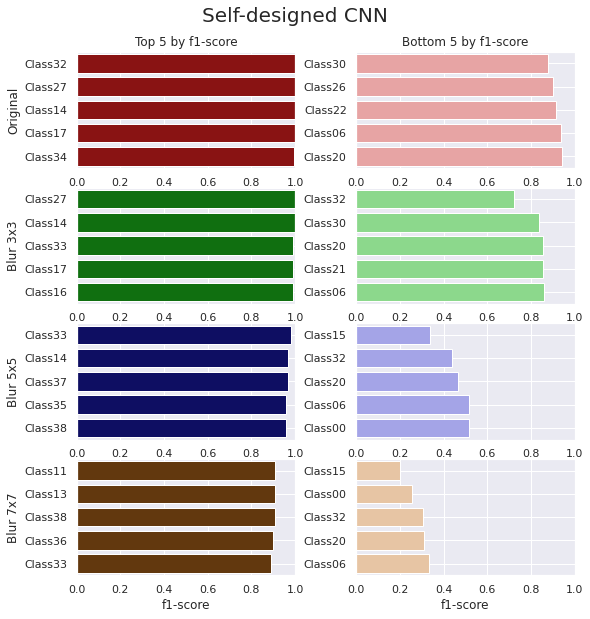

In [ ]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(8, 8))
sns.set_style('darkgrid')

sns.barplot(y = 'index', x = 'f1-score', data=self_df_top, ax=ax[0,0], color='#9c0000')
ax[0,0].set_xlim([0, 1.0])
ax[0,0].set_ylabel('Original')
ax[0,0].set_title('Top 5 by f1-score')
ax[0,0].set_xlabel("")
ax[0,0].grid(True)

sns.barplot(y = 'index', x = 'f1-score', data=self_df_bottom, ax=ax[0,1], color='#f29999')
ax[0,1].set_xlim([0, 1.0])
ax[0,1].set_title('Bottom 5 by f1-score')
ax[0,1].set_xlabel("")
ax[0,1].set_ylabel("")
ax[0,1].grid(True)

sns.barplot(y = 'index', x = 'f1-score', data=self_df_top_3, ax=ax[1,0], color='#007F00')
ax[1,0].set_xlabel("")
ax[1,0].set_ylabel('Blur 3x3')
ax[1,0].set_xlim([0, 1.0])
ax[1,0].grid(True)

sns.barplot(y = 'index', x = 'f1-score', data=self_df_bottom_3, ax=ax[1,1], color='#7fe57f')
ax[1,1].set_xlim([0, 1.0])
ax[1,1].set_xlabel("")
ax[1,1].set_ylabel("")
ax[1,1].grid(True)

sns.barplot(y = 'index', x = 'f1-score', data=self_df_top_5, ax=ax[2,0], color='#000070')
ax[2,0].set_xlabel("")
ax[2,0].set_ylabel('Blur 5x5')
ax[2,0].set_xlim([0, 1.0])
ax[2,0].grid(True)

sns.barplot(y = 'index', x = 'f1-score', data=self_df_bottom_5, ax=ax[2,1], color='#9999f2')
ax[2,1].set_xlim([0, 1.0])
ax[2,1].set_xlabel("")
ax[2,1].set_ylabel("")
ax[2,1].grid(True)

sns.barplot(y = 'index', x = 'f1-score', data=self_df_top_7, ax=ax[3,0], color='#703800')
ax[3,0].set_ylabel('Blur 7x7')
ax[3,0].set_xlim([0, 1.0])
ax[3,0].grid(True)

sns.barplot(y = 'index', x = 'f1-score', data=self_df_bottom_7, ax=ax[3,1], color='#f2c599')
ax[3,1].set_xlim([0, 1.0])
ax[3,1].set_ylabel("")
ax[3,1].grid(True)

fig.tight_layout(pad=0)
fig.suptitle('Self-designed CNN', position=(0.5, 1.05), fontsize=20)

fig.savefig(os.path.join(visualization_path, 'Self_f1_scores.png'), dpi=300, bbox_inches='tight')

## Inception Model

In [ ]:
#Load the InceptionV3 model

inception_pretrained_model = InceptionV3(input_shape = (75, 75, 3), 
                        include_top = False, 
                        weights = 'imagenet')

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
# Set training of pre-trained model to false.

for layer in inception_pretrained_model.layers:
     layer.trainable = False

In [ ]:
# The last layer of pre-trained model.

# inception_pretrained_model.summary()
inception_last_layer = inception_pretrained_model.get_layer('mixed7')
print('last layer output shape: ', inception_last_layer.output_shape)
inception_last_output = inception_last_layer.output

last layer output shape:  (None, 3, 3, 768)


In [ ]:
# Classifier Layer.

inception_x = layers.Flatten()(inception_last_output)
inception_x = layers.Dense(1024, activation='relu')(inception_x)
inception_x = layers.Dropout(0.2)(inception_x)                  
inception_x = layers.Dense(classes, activation='softmax')(inception_x)

In [ ]:
# # Classifier Layer.

# model_classifier = layers.Flatten()(model_last_layer)
# model_classifier = layers.Dense(1024, activation='relu')(model_classifier)
# model_classifier = layers.Dropout(0.2)(model_classifier)                  
# model_classifier = layers.Dense(classes, activation='softmax')(model_classifier)

In [ ]:
# Final Model.

inception_model = Model(inception_pretrained_model.input, inception_x) 

In [ ]:
# Compiling Model.

inception_model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['acc'])

In [ ]:
# Using twenty epochs for the training and saving the accuracy for each epoch

inception_epochs = 20
inception_batch_size = 32

start_time = time.time()

inception_history = inception_model.fit(X_train, y_train, batch_size=inception_batch_size, 
                        epochs=inception_epochs, validation_data = (X_val, y_val))

inception_training_time = time.time()-start_time

Epoch 1/20
981/981 [==============================] - 18s 18ms/step - loss: 0.8130 - acc: 0.7583 - val_loss: 0.3404 - val_acc: 0.8959
Epoch 2/20
981/981 [==============================] - 16s 17ms/step - loss: 0.2384 - acc: 0.9289 - val_loss: 0.1826 - val_acc: 0.9448
Epoch 3/20
981/981 [==============================] - 16s 17ms/step - loss: 0.1324 - acc: 0.9595 - val_loss: 0.1775 - val_acc: 0.9454
Epoch 4/20
981/981 [==============================] - 16s 17ms/step - loss: 0.0830 - acc: 0.9746 - val_loss: 0.1679 - val_acc: 0.9480
Epoch 5/20
981/981 [==============================] - 16s 17ms/step - loss: 0.0560 - acc: 0.9833 - val_loss: 0.1552 - val_acc: 0.9481
Epoch 6/20
981/981 [==============================] - 16s 17ms/step - loss: 0.0420 - acc: 0.9881 - val_loss: 0.0996 - val_acc: 0.9686
Epoch 7/20
981/981 [==============================] - 16s 17ms/step - loss: 0.0303 - acc: 0.9913 - val_loss: 0.0961 - val_acc: 0.9705
Epoch 8/20
981/981 [==============================] - 16s 17ms

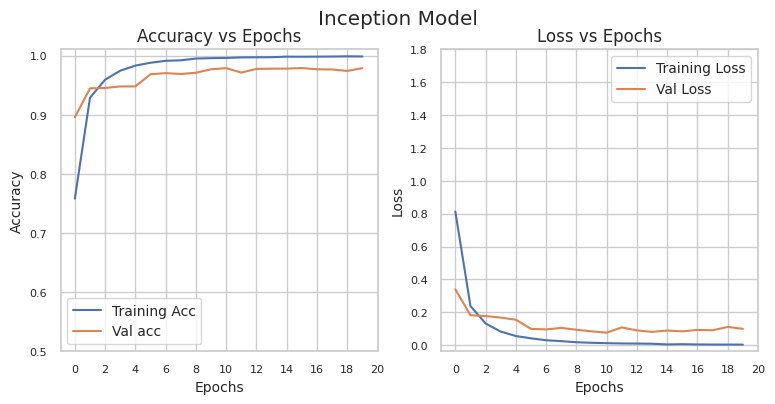

In [ ]:
# Plot of Accuracy and Loss vs Epochs

sns.set_style('whitegrid')
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 4), dpi=100)


fig.suptitle("Inception Model", fontdict = {'fontsize': 10, 'fontweight' : 3})

ax[0].set_title('Accuracy vs Epochs')
ax[0].plot(inception_history.history['acc'], label='Training Acc')
ax[0].plot(inception_history.history['val_acc'], label='Val acc')
ax[0].set_xlabel('Epochs', fontsize=10)
ax[0].set_ylabel('Accuracy', fontsize=10)
ax[0].legend(fontsize=10)
ax[0].tick_params(axis='both', which='major', labelsize=8)
ax[0].xaxis.set_ticks(np.arange(0, 21, 2))
ax[0].yaxis.set_ticks(np.arange(0.5, 1.05, 0.1))

ax[1].set_title('Loss vs Epochs')
ax[1].plot(inception_history.history['loss'], label='Training Loss')
ax[1].plot(inception_history.history['val_loss'], label='Val Loss')
ax[1].set_xlabel('Epochs', fontsize=10)
ax[1].set_ylabel('Loss', fontsize=10)
ax[1].legend(fontsize=10)
ax[1].tick_params(axis='both', which='major', labelsize=8)
ax[1].xaxis.set_ticks(np.arange(0, 21, 2))
ax[1].yaxis.set_ticks(np.arange(0, 1.9, 0.2))

fig.savefig(os.path.join(visualization_path, 'inception_acc_loss.png'), dpi=300, bbox_inches='tight')

In [ ]:
# Predicting output.

inception_pred = inception_model.predict(X_test)
inception_pred_3 = inception_model.predict(X_test_3)
inception_pred_5 = inception_model.predict(X_test_5)
inception_pred_7 = inception_model.predict(X_test_7)

In [ ]:
# Prediction accuracy of Original Images.

inception_acc_original = accuracy_score(y_test, np.argmax(inception_pred, axis=1))
inception_acc_original

0.805938242280285

In [ ]:
# Prediction accuracy with images blurred at level 3.

inception_acc_3 = accuracy_score(y_test, np.argmax(inception_pred_3, axis=1))
inception_acc_3

0.6954077593032463

In [ ]:
# Prediction accuracy with images blurred at level 5.

inception_acc_5 = accuracy_score(y_test, np.argmax(inception_pred_5, axis=1))
inception_acc_5

0.5406967537608868

In [ ]:
# Prediction accuracy with images blurred at level 7.

inception_acc_7 = accuracy_score(y_test, np.argmax(inception_pred_7, axis=1))
inception_acc_7

0.40791765637371336

### Classification Report

In [ ]:
# Classification report of Original images test data.

inception_class_report = classification_report(y_test, np.argmax(inception_pred, axis=1), target_names = traffic_class_list, output_dict=True)
print(classification_report(y_test, np.argmax(inception_pred, axis=1), target_names = traffic_class_list))

              precision    recall  f1-score   support

     Class00       0.65      0.28      0.40        60
     Class01       0.77      0.79      0.78       720
     Class02       0.68      0.59      0.63       750
     Class03       0.54      0.67      0.60       450
     Class04       0.88      0.72      0.79       660
     Class05       0.68      0.76      0.72       630
     Class06       0.98      0.81      0.89       150
     Class07       0.80      0.86      0.83       450
     Class08       0.73      0.80      0.76       450
     Class09       0.92      0.94      0.93       480
     Class10       0.89      0.97      0.93       660
     Class11       0.82      0.75      0.78       420
     Class12       0.99      0.98      0.98       690
     Class13       0.97      0.99      0.98       720
     Class14       0.94      0.99      0.96       270
     Class15       1.00      0.99      0.99       210
     Class16       0.99      0.91      0.94       150
     Class17       0.95    

In [ ]:
# Classification report of 3x3 images test data.

inception_class_report_3 = classification_report(y_test, np.argmax(inception_pred_3, axis=1), target_names = traffic_class_list, output_dict=True)
print(classification_report(y_test, np.argmax(inception_pred_3, axis=1), target_names = traffic_class_list))

              precision    recall  f1-score   support

     Class00       1.00      0.10      0.18        60
     Class01       0.74      0.65      0.69       720
     Class02       0.61      0.50      0.55       750
     Class03       0.45      0.54      0.50       450
     Class04       0.88      0.43      0.58       660
     Class05       0.47      0.67      0.55       630
     Class06       0.89      0.57      0.69       150
     Class07       0.52      0.59      0.56       450
     Class08       0.49      0.65      0.56       450
     Class09       0.94      0.67      0.78       480
     Class10       0.51      0.94      0.66       660
     Class11       0.64      0.67      0.66       420
     Class12       0.97      0.94      0.96       690
     Class13       0.94      0.97      0.95       720
     Class14       1.00      0.84      0.91       270
     Class15       0.96      0.97      0.96       210
     Class16       0.96      0.89      0.92       150
     Class17       0.87    

In [ ]:
# Classification report of 5x5 images test data.

inception_class_report_5 = classification_report(y_test, np.argmax(inception_pred_5, axis=1), target_names = traffic_class_list, output_dict=True)
print(classification_report(y_test, np.argmax(inception_pred_5, axis=1), 
                            target_names = traffic_class_list))

              precision    recall  f1-score   support

     Class00       0.00      0.00      0.00        60
     Class01       0.72      0.44      0.55       720
     Class02       0.47      0.38      0.42       750
     Class03       0.25      0.33      0.28       450
     Class04       0.80      0.14      0.24       660
     Class05       0.29      0.64      0.40       630
     Class06       0.40      0.22      0.28       150
     Class07       0.34      0.41      0.37       450
     Class08       0.32      0.42      0.36       450
     Class09       0.97      0.39      0.56       480
     Class10       0.31      0.83      0.45       660
     Class11       0.58      0.63      0.60       420
     Class12       0.95      0.81      0.88       690
     Class13       0.90      0.95      0.93       720
     Class14       0.97      0.66      0.78       270
     Class15       0.90      0.77      0.83       210
     Class16       0.96      0.64      0.77       150
     Class17       0.68    

In [ ]:
# Classification report of 7x7 images test data.

inception_class_report_7 = classification_report(y_test, np.argmax(inception_pred_7, axis=1), target_names = traffic_class_list, output_dict=True)
print(classification_report(y_test, np.argmax(inception_pred_7, axis=1), 
                            target_names = traffic_class_list))

              precision    recall  f1-score   support

     Class00       0.00      0.00      0.00        60
     Class01       0.70      0.28      0.40       720
     Class02       0.36      0.26      0.30       750
     Class03       0.14      0.25      0.18       450
     Class04       0.65      0.07      0.12       660
     Class05       0.21      0.62      0.31       630
     Class06       0.36      0.11      0.17       150
     Class07       0.26      0.26      0.26       450
     Class08       0.22      0.31      0.25       450
     Class09       0.91      0.19      0.32       480
     Class10       0.20      0.73      0.32       660
     Class11       0.47      0.55      0.51       420
     Class12       0.90      0.66      0.76       690
     Class13       0.84      0.85      0.84       720
     Class14       0.94      0.42      0.58       270
     Class15       0.91      0.58      0.71       210
     Class16       0.89      0.45      0.60       150
     Class17       0.54    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Visualizations of Top and Bottom 5 classes.

In [ ]:
inception_df_top = pd.DataFrame(inception_class_report).transpose().sort_values(by='f1-score', ascending=False)[:5]
inception_df_top.reset_index(inplace=True)
inception_df_bottom = pd.DataFrame(inception_class_report).transpose().sort_values(by='f1-score', ascending=True)[:5]
inception_df_bottom.reset_index(inplace=True)

inception_df_top_3 = pd.DataFrame(inception_class_report_3).transpose().sort_values(by='f1-score', ascending=False)[:5]
inception_df_top_3.reset_index(inplace=True)
inception_df_bottom_3 = pd.DataFrame(inception_class_report_3).transpose().sort_values(by='f1-score', ascending=True)[:5]
inception_df_bottom_3.reset_index(inplace=True)

inception_df_top_5 = pd.DataFrame(inception_class_report_5).transpose().sort_values(by='f1-score', ascending=False)[:5]
inception_df_top_5.reset_index(inplace=True)
inception_df_bottom_5 = pd.DataFrame(inception_class_report_5).transpose().sort_values(by='f1-score', ascending=True)[:5]
inception_df_bottom_5.reset_index(inplace=True)

inception_df_top_7 = pd.DataFrame(inception_class_report_7).transpose().sort_values(by='f1-score', ascending=False)[:5]
inception_df_top_7.reset_index(inplace=True)
inception_df_bottom_7 = pd.DataFrame(inception_class_report_7).transpose().sort_values(by='f1-score', ascending=True)[:5]
inception_df_bottom_7.reset_index(inplace=True)

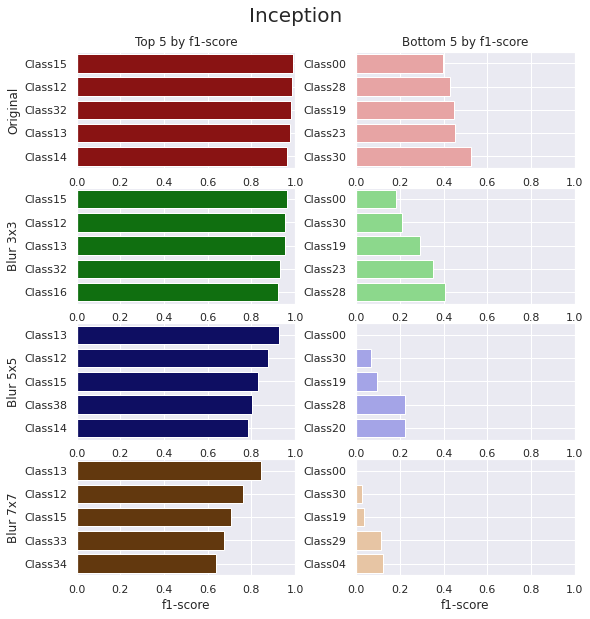

In [ ]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(8, 8))
sns.set_style('darkgrid')

sns.barplot(y = 'index', x = 'f1-score', data=inception_df_top, ax=ax[0,0], color='#9c0000')
ax[0,0].set_xlim([0, 1.0])
ax[0,0].set_ylabel('Original')
ax[0,0].set_title('Top 5 by f1-score')
ax[0,0].set_xlabel("")
ax[0,0].grid(True)

sns.barplot(y = 'index', x = 'f1-score', data=inception_df_bottom, ax=ax[0,1], color='#f29999')
ax[0,1].set_xlim([0, 1.0])
ax[0,1].set_title('Bottom 5 by f1-score')
ax[0,1].set_xlabel("")
ax[0,1].set_ylabel("")
ax[0,1].grid(True)

sns.barplot(y = 'index', x = 'f1-score', data=inception_df_top_3, ax=ax[1,0], color='#007F00')
ax[1,0].set_xlabel("")
ax[1,0].set_ylabel('Blur 3x3')
ax[1,0].set_xlim([0, 1.0])
ax[1,0].grid(True)

sns.barplot(y = 'index', x = 'f1-score', data=inception_df_bottom_3, ax=ax[1,1], color='#7fe57f')
ax[1,1].set_xlim([0, 1.0])
ax[1,1].set_xlabel("")
ax[1,1].set_ylabel("")
ax[1,1].grid(True)

sns.barplot(y = 'index', x = 'f1-score', data=inception_df_top_5, ax=ax[2,0], color='#000070')
ax[2,0].set_xlabel("")
ax[2,0].set_ylabel('Blur 5x5')
ax[2,0].set_xlim([0, 1.0])
ax[2,0].grid(True)

sns.barplot(y = 'index', x = 'f1-score', data=inception_df_bottom_5, ax=ax[2,1], color='#9999f2')
ax[2,1].set_xlim([0, 1.0])
ax[2,1].set_xlabel("")
ax[2,1].set_ylabel("")
ax[2,1].grid(True)

sns.barplot(y = 'index', x = 'f1-score', data=inception_df_top_7, ax=ax[3,0], color='#703800')
ax[3,0].set_ylabel('Blur 7x7')
ax[3,0].set_xlim([0, 1.0])
ax[3,0].grid(True)

sns.barplot(y = 'index', x = 'f1-score', data=inception_df_bottom_7, ax=ax[3,1], color='#f2c599')
ax[3,1].set_xlim([0, 1.0])
ax[3,1].set_ylabel("")
ax[3,1].grid(True)

fig.tight_layout(pad=0)
fig.suptitle('Inception', position=(0.5, 1.05), fontsize=20)

fig.savefig(os.path.join(visualization_path, 'inception_f1_scores.png'), dpi=300, bbox_inches='tight')

## VGG16 Model

In [ ]:
#Load the VGG19 model

vgg16_pretrained_model = VGG16(input_shape = (width, height, channels), 
                        include_top = False, 
                        weights = 'imagenet')

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
# Set training of pre-trained model to false.

for layer in vgg16_pretrained_model.layers:
     layer.trainable = False

In [ ]:
# The last layer of pre-trained model.

# vgg_model.summary()
vgg16_last_layer = vgg16_pretrained_model.get_layer('block5_pool')
print('last layer of vgg : output shape: ', vgg16_last_layer.output_shape)
vgg16_last_output= vgg16_last_layer.output

last layer of vgg : output shape:  (None, 2, 2, 512)


In [ ]:
# Classifier Layer.

vgg16_x = layers.Flatten()(vgg16_last_output)
vgg16_x = layers.Dense(1024, activation='relu')(vgg16_x)
vgg16_x = layers.Dropout(0.2)(vgg16_x)                  
vgg16_x = layers.Dense(43, activation='softmax')(vgg16_x)   

In [ ]:
# Final Model.

vgg16_model = Model(vgg16_pretrained_model.input, vgg16_x) 

In [ ]:
# Compiling Model.

vgg16_model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['acc'])

In [ ]:
#using twenty epochs for the training and saving the accuracy for each epoch


vgg16_epochs = 20
vgg16_batch_size = 32

start_time = time.time()

vgg16_history = vgg16_model.fit(X_train, y_train, batch_size=vgg16_batch_size, 
                        epochs=vgg16_epochs, validation_data = (X_val, y_val))

vgg16_training_time = time.time()-start_time

Epoch 1/20
981/981 [==============================] - 33s 34ms/step - loss: 1.7123 - acc: 0.5162 - val_loss: 1.2154 - val_acc: 0.6191
Epoch 2/20
981/981 [==============================] - 34s 34ms/step - loss: 0.9981 - acc: 0.7036 - val_loss: 0.8252 - val_acc: 0.7739
Epoch 3/20
981/981 [==============================] - 33s 34ms/step - loss: 0.7474 - acc: 0.7823 - val_loss: 0.7052 - val_acc: 0.7911
Epoch 4/20
981/981 [==============================] - 33s 34ms/step - loss: 0.5982 - acc: 0.8302 - val_loss: 0.5558 - val_acc: 0.8444
Epoch 5/20
981/981 [==============================] - 33s 34ms/step - loss: 0.4985 - acc: 0.8557 - val_loss: 0.4644 - val_acc: 0.8718
Epoch 6/20
981/981 [==============================] - 33s 34ms/step - loss: 0.4233 - acc: 0.8819 - val_loss: 0.4300 - val_acc: 0.8754
Epoch 7/20
981/981 [==============================] - 33s 34ms/step - loss: 0.3682 - acc: 0.8960 - val_loss: 0.3730 - val_acc: 0.8945
Epoch 8/20
981/981 [==============================] - 33s 34ms

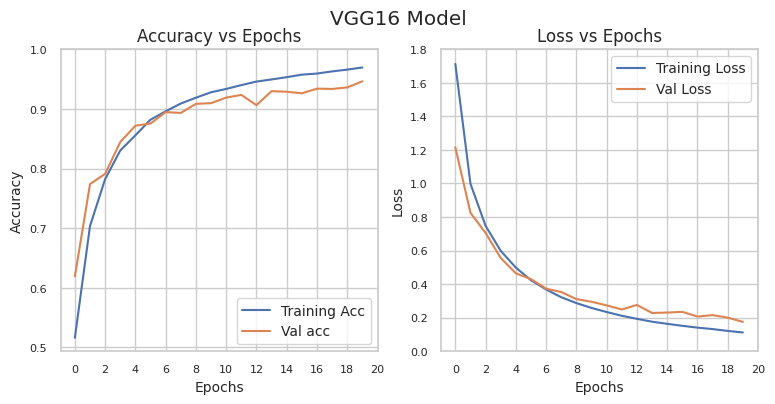

In [ ]:
# Plot of Accuracy and Loss vs Epochs

sns.set_style('whitegrid')
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 4), dpi=100)


fig.suptitle("VGG16 Model", fontdict = {'fontsize': 10, 'fontweight' : 3})

ax[0].set_title('Accuracy vs Epochs')
ax[0].plot(vgg16_history.history['acc'], label='Training Acc')
ax[0].plot(vgg16_history.history['val_acc'], label='Val acc')
ax[0].set_xlabel('Epochs', fontsize=10)
ax[0].set_ylabel('Accuracy', fontsize=10)
ax[0].legend(fontsize=10)
ax[0].tick_params(axis='both', which='major', labelsize=8)
ax[0].xaxis.set_ticks(np.arange(0, 21, 2))
ax[0].yaxis.set_ticks(np.arange(0.5, 1.05, 0.1))

ax[1].set_title('Loss vs Epochs')
ax[1].plot(vgg16_history.history['loss'], label='Training Loss')
ax[1].plot(vgg16_history.history['val_loss'], label='Val Loss')
ax[1].set_xlabel('Epochs', fontsize=10)
ax[1].set_ylabel('Loss', fontsize=10)
ax[1].legend(fontsize=10)
ax[1].tick_params(axis='both', which='major', labelsize=8)
ax[1].xaxis.set_ticks(np.arange(0, 21, 2))
ax[1].yaxis.set_ticks(np.arange(0, 1.9, 0.2))

fig.savefig(os.path.join(visualization_path, 'vgg16_acc_loss.png'), dpi=300, bbox_inches='tight')

In [ ]:
# Predicting output.

vgg16_pred = vgg16_model.predict(X_test)
# print(vgg16_pred.shape)
vgg16_pred_3 = vgg16_model.predict(X_test_3)
vgg16_pred_5 = vgg16_model.predict(X_test_5)
vgg16_pred_7 = vgg16_model.predict(X_test_7)

In [ ]:
# Prediction accuracy of Original Images.

vgg16_acc_original = accuracy_score(y_test, np.argmax(vgg16_pred, axis=1))
vgg16_acc_original

0.7501979414093428

In [ ]:
# Prediction accuracy with images blurred at level 3.

vgg16_acc_3 = accuracy_score(y_test, np.argmax(vgg16_pred_3, axis=1))
vgg16_acc_3

0.6227236737925574

In [ ]:
# Prediction accuracy with images blurred at level 5.

vgg16_acc_5 = accuracy_score(y_test, np.argmax(vgg16_pred_5, axis=1))
vgg16_acc_5

0.4651623119556611

In [ ]:
# Prediction accuracy with images blurred at level 7.

vgg16_acc_7 = accuracy_score(y_test, np.argmax(vgg16_pred_7, axis=1))
vgg16_acc_7

0.35471100554235946

### Classification Report

In [ ]:
# Classification report of Original images test data.

vgg16_class_report = classification_report(y_test, np.argmax(vgg16_pred, axis=1), target_names = traffic_class_list, output_dict=True)
print(classification_report(y_test, np.argmax(vgg16_pred, axis=1), 
                            target_names = traffic_class_list))

              precision    recall  f1-score   support

     Class00       0.44      0.35      0.39        60
     Class01       0.75      0.74      0.74       720
     Class02       0.58      0.69      0.63       750
     Class03       0.62      0.49      0.55       450
     Class04       0.65      0.73      0.69       660
     Class05       0.66      0.71      0.69       630
     Class06       0.91      0.70      0.79       150
     Class07       0.80      0.81      0.80       450
     Class08       0.68      0.65      0.66       450
     Class09       0.88      0.79      0.83       480
     Class10       0.76      0.85      0.80       660
     Class11       0.62      0.68      0.65       420
     Class12       0.97      0.97      0.97       690
     Class13       0.97      0.97      0.97       720
     Class14       0.93      0.92      0.92       270
     Class15       0.96      0.99      0.98       210
     Class16       1.00      0.81      0.89       150
     Class17       0.97    

In [ ]:
# Classification report of 3x3 images test data.

vgg16_class_report_3 = classification_report(y_test, np.argmax(vgg16_pred_3, axis=1), target_names = traffic_class_list, output_dict=True)
print(classification_report(y_test, np.argmax(vgg16_pred_3, axis=1), 
                            target_names = traffic_class_list))

              precision    recall  f1-score   support

     Class00       0.37      0.12      0.18        60
     Class01       0.67      0.62      0.64       720
     Class02       0.51      0.30      0.37       750
     Class03       0.39      0.28      0.33       450
     Class04       0.61      0.47      0.53       660
     Class05       0.49      0.58      0.53       630
     Class06       0.61      0.51      0.55       150
     Class07       0.60      0.57      0.58       450
     Class08       0.39      0.45      0.42       450
     Class09       0.46      0.55      0.50       480
     Class10       0.42      0.84      0.56       660
     Class11       0.46      0.70      0.55       420
     Class12       0.98      0.91      0.94       690
     Class13       0.86      0.97      0.91       720
     Class14       1.00      0.75      0.86       270
     Class15       0.94      0.94      0.94       210
     Class16       0.85      0.69      0.76       150
     Class17       0.85    

In [ ]:
# Classification report of 5x5 images test data.

vgg16_class_report_5 = classification_report(y_test, np.argmax(vgg16_pred_5, axis=1), target_names = traffic_class_list, output_dict=True)
print(classification_report(y_test, np.argmax(vgg16_pred_5, axis=1), 
                            target_names = traffic_class_list))

              precision    recall  f1-score   support

     Class00       0.38      0.05      0.09        60
     Class01       0.66      0.44      0.53       720
     Class02       0.56      0.12      0.20       750
     Class03       0.23      0.10      0.14       450
     Class04       0.55      0.17      0.25       660
     Class05       0.35      0.47      0.40       630
     Class06       0.45      0.40      0.42       150
     Class07       0.46      0.28      0.35       450
     Class08       0.18      0.25      0.21       450
     Class09       0.15      0.34      0.21       480
     Class10       0.30      0.70      0.42       660
     Class11       0.35      0.85      0.50       420
     Class12       0.96      0.75      0.84       690
     Class13       0.62      0.93      0.74       720
     Class14       0.96      0.60      0.74       270
     Class15       0.90      0.68      0.77       210
     Class16       0.82      0.45      0.58       150
     Class17       0.46    

In [ ]:
# Classification report of 7x7 images test data.

vgg16_class_report_7 = classification_report(y_test, np.argmax(vgg16_pred_7, axis=1), target_names = traffic_class_list, output_dict=True)
print(classification_report(y_test, np.argmax(vgg16_pred_7, axis=1), 
                            target_names = traffic_class_list)) 

              precision    recall  f1-score   support

     Class00       0.00      0.00      0.00        60
     Class01       0.58      0.30      0.40       720
     Class02       0.47      0.05      0.09       750
     Class03       0.14      0.06      0.08       450
     Class04       0.44      0.08      0.14       660
     Class05       0.32      0.32      0.32       630
     Class06       0.31      0.29      0.30       150
     Class07       0.38      0.14      0.21       450
     Class08       0.12      0.13      0.13       450
     Class09       0.08      0.28      0.12       480
     Class10       0.23      0.54      0.33       660
     Class11       0.32      0.84      0.46       420
     Class12       0.91      0.62      0.74       690
     Class13       0.50      0.86      0.64       720
     Class14       0.98      0.44      0.61       270
     Class15       0.93      0.44      0.60       210
     Class16       0.85      0.33      0.48       150
     Class17       0.26    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Visualizations of Top and Bottom 5 classes.

In [ ]:
vgg16_df_top = pd.DataFrame(vgg16_class_report).transpose().sort_values(by='f1-score', ascending=False)[:5]
vgg16_df_top.reset_index(inplace=True)
vgg16_df_bottom = pd.DataFrame(vgg16_class_report).transpose().sort_values(by='f1-score', ascending=True)[:5]
vgg16_df_bottom.reset_index(inplace=True)

vgg16_df_top_3 = pd.DataFrame(vgg16_class_report_3).transpose().sort_values(by='f1-score', ascending=False)[:5]
vgg16_df_top_3.reset_index(inplace=True)
vgg16_df_bottom_3 = pd.DataFrame(vgg16_class_report_3).transpose().sort_values(by='f1-score', ascending=True)[:5]
vgg16_df_bottom_3.reset_index(inplace=True)

vgg16_df_top_5 = pd.DataFrame(vgg16_class_report_5).transpose().sort_values(by='f1-score', ascending=False)[:5]
vgg16_df_top_5.reset_index(inplace=True)
vgg16_df_bottom_5 = pd.DataFrame(vgg16_class_report_5).transpose().sort_values(by='f1-score', ascending=True)[:5]
vgg16_df_bottom_5.reset_index(inplace=True)

vgg16_df_top_7 = pd.DataFrame(vgg16_class_report_7).transpose().sort_values(by='f1-score', ascending=False)[:5]
vgg16_df_top_7.reset_index(inplace=True)
vgg16_df_bottom_7 = pd.DataFrame(vgg16_class_report_7).transpose().sort_values(by='f1-score', ascending=True)[:5]
vgg16_df_bottom_7.reset_index(inplace=True)

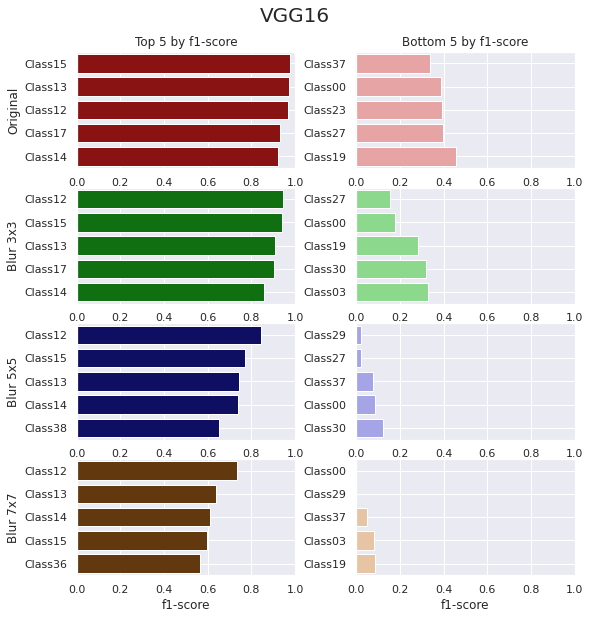

In [ ]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(8, 8))
sns.set_style('darkgrid')

sns.barplot(y = 'index', x = 'f1-score', data=vgg16_df_top, ax=ax[0,0], color='#9c0000')
ax[0,0].set_xlim([0, 1.0])
ax[0,0].set_ylabel('Original')
ax[0,0].set_title('Top 5 by f1-score')
ax[0,0].set_xlabel("")
ax[0,0].grid(True)

sns.barplot(y = 'index', x = 'f1-score', data=vgg16_df_bottom, ax=ax[0,1], color='#f29999')
ax[0,1].set_xlim([0, 1.0])
ax[0,1].set_title('Bottom 5 by f1-score')
ax[0,1].set_xlabel("")
ax[0,1].set_ylabel("")
ax[0,1].grid(True)

sns.barplot(y = 'index', x = 'f1-score', data=vgg16_df_top_3, ax=ax[1,0], color='#007F00')
ax[1,0].set_xlabel("")
ax[1,0].set_ylabel('Blur 3x3')
ax[1,0].set_xlim([0, 1.0])
ax[1,0].grid(True)

sns.barplot(y = 'index', x = 'f1-score', data=vgg16_df_bottom_3, ax=ax[1,1], color='#7fe57f')
ax[1,1].set_xlim([0, 1.0])
ax[1,1].set_xlabel("")
ax[1,1].set_ylabel("")
ax[1,1].grid(True)

sns.barplot(y = 'index', x = 'f1-score', data=vgg16_df_top_5, ax=ax[2,0], color='#000070')
ax[2,0].set_xlabel("")
ax[2,0].set_ylabel('Blur 5x5')
ax[2,0].set_xlim([0, 1.0])
ax[2,0].grid(True)

sns.barplot(y = 'index', x = 'f1-score', data=vgg16_df_bottom_5, ax=ax[2,1], color='#9999f2')
ax[2,1].set_xlim([0, 1.0])
ax[2,1].set_xlabel("")
ax[2,1].set_ylabel("")
ax[2,1].grid(True)

sns.barplot(y = 'index', x = 'f1-score', data=vgg16_df_top_7, ax=ax[3,0], color='#703800')
ax[3,0].set_ylabel('Blur 7x7')
ax[3,0].set_xlim([0, 1.0])
ax[3,0].grid(True)

sns.barplot(y = 'index', x = 'f1-score', data=vgg16_df_bottom_7, ax=ax[3,1], color='#f2c599')
ax[3,1].set_xlim([0, 1.0])
ax[3,1].set_ylabel("")
ax[3,1].grid(True)

fig.tight_layout(pad=0)
fig.suptitle('VGG16', position=(0.5, 1.05), fontsize=20)

fig.savefig(os.path.join(visualization_path, 'vgg16_f1_scores.png'), dpi=300, bbox_inches='tight')

## VGG19 Model

In [ ]:
#Load the VGG19 model

vgg19_pretrained_model = VGG19(input_shape = (width, height, 3), 
                        include_top = False, 
                        weights = 'imagenet')

80142336/80134624 [==============================] - 0s 0us/step


In [ ]:
# Set training of pre-trained model to false.

for layer in vgg19_pretrained_model.layers:
     layer.trainable = False

In [ ]:
# The last layer of pre-trained model.

# vgg_model.summary()
vgg19_last_layer = vgg19_pretrained_model.get_layer('block5_pool')
print('last layer of vgg : output shape: ', vgg19_last_layer.output_shape)
vgg19_last_output = vgg19_last_layer.output

last layer of vgg : output shape:  (None, 2, 2, 512)


In [ ]:
# Classifier Layer.

vgg19_x = layers.Flatten()(vgg19_last_output)
vgg19_x = layers.Dense(1024, activation='relu')(vgg19_x)
vgg19_x = layers.Dropout(0.2)(vgg19_x)                  
vgg19_x = layers.Dense(classes, activation='softmax')(vgg19_x)    

In [ ]:
# Final Model.

vgg19_model = Model(vgg19_pretrained_model.input, vgg19_x) 

In [ ]:
# Compiling Model.

vgg19_model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['acc'])

In [ ]:
# Using twenty epochs for the training and saving the accuracy for each epoch

epochs = 20
vgg19_batch_size=32

start_time = time.time()

vgg19_history = vgg19_model.fit(X_train, y_train, batch_size=vgg19_batch_size, 
                        epochs=epochs, validation_data = (X_val, y_val))

vgg19_training_time = time.time()-start_time

Epoch 1/20
981/981 [==============================] - 41s 42ms/step - loss: 1.8765 - acc: 0.4716 - val_loss: 1.3766 - val_acc: 0.5831
Epoch 2/20
981/981 [==============================] - 40s 41ms/step - loss: 1.1875 - acc: 0.6524 - val_loss: 1.0464 - val_acc: 0.6924
Epoch 3/20
981/981 [==============================] - 40s 41ms/step - loss: 0.9384 - acc: 0.7268 - val_loss: 0.8834 - val_acc: 0.7331
Epoch 4/20
981/981 [==============================] - 40s 41ms/step - loss: 0.7867 - acc: 0.7679 - val_loss: 0.7602 - val_acc: 0.7646
Epoch 5/20
981/981 [==============================] - 40s 40ms/step - loss: 0.6795 - acc: 0.7987 - val_loss: 0.7019 - val_acc: 0.7808
Epoch 6/20
981/981 [==============================] - 40s 41ms/step - loss: 0.6005 - acc: 0.8263 - val_loss: 0.5920 - val_acc: 0.8246
Epoch 7/20
981/981 [==============================] - 40s 41ms/step - loss: 0.5383 - acc: 0.8416 - val_loss: 0.5837 - val_acc: 0.8129
Epoch 8/20
981/981 [==============================] - 40s 41ms

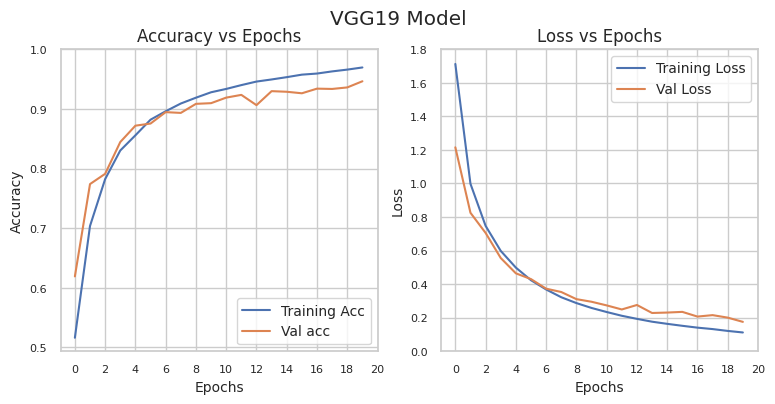

In [ ]:
# Plot of Accuracy and Loss vs Epochs

sns.set_style('whitegrid')
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 4), dpi=100)


fig.suptitle("VGG19 Model", fontdict = {'fontsize': 10, 'fontweight' : 3})

ax[0].set_title('Accuracy vs Epochs')
ax[0].plot(vgg16_history.history['acc'], label='Training Acc')
ax[0].plot(vgg16_history.history['val_acc'], label='Val acc')
ax[0].set_xlabel('Epochs', fontsize=10)
ax[0].set_ylabel('Accuracy', fontsize=10)
ax[0].legend(fontsize=10)
ax[0].tick_params(axis='both', which='major', labelsize=8)
ax[0].xaxis.set_ticks(np.arange(0, 21, 2))
ax[0].yaxis.set_ticks(np.arange(0.5, 1.05, 0.1))

ax[1].set_title('Loss vs Epochs')
ax[1].plot(vgg16_history.history['loss'], label='Training Loss')
ax[1].plot(vgg16_history.history['val_loss'], label='Val Loss')
ax[1].set_xlabel('Epochs', fontsize=10)
ax[1].set_ylabel('Loss', fontsize=10)
ax[1].legend(fontsize=10)
ax[1].tick_params(axis='both', which='major', labelsize=8)
ax[1].xaxis.set_ticks(np.arange(0, 21, 2))
ax[1].yaxis.set_ticks(np.arange(0, 1.9, 0.2))

fig.savefig(os.path.join(visualization_path, 'vgg19_acc_loss.png'), dpi=300, bbox_inches='tight')

In [ ]:
# Predicting output.

vgg19_pred = vgg19_model.predict(X_test)
# print(vgg19_pred.shape)
vgg19_pred_3 = vgg19_model.predict(X_test_3)
vgg19_pred_5 = vgg19_model.predict(X_test_5)
vgg19_pred_7 = vgg19_model.predict(X_test_7)

In [ ]:
# Prediction accuracy of Original Images.

vgg19_acc_original = accuracy_score(y_test, np.argmax(vgg19_pred, axis=1))
vgg19_acc_original

0.6965954077593033

In [ ]:
# Prediction accuracy with images blurred at level 3.

vgg19_acc_3 = accuracy_score(y_test, np.argmax(vgg19_pred_3, axis=1))
vgg19_acc_3

0.5797307996832938

In [ ]:
# Prediction accuracy with images blurred at level 5.

vgg19_acc_5 = accuracy_score(y_test, np.argmax(vgg19_pred_5, axis=1))
vgg19_acc_5

0.4300870942201108

In [ ]:
# Prediction accuracy with images blurred at level 7.

vgg19_acc_7 = accuracy_score(y_test, np.argmax(vgg19_pred_7, axis=1))
vgg19_acc_7

0.34156769596199527

### Classification Report

In [ ]:
# Classification report of Original images test data.

vgg19_class_report = classification_report(y_test, np.argmax(vgg19_pred, axis=1), target_names = traffic_class_list, output_dict=True)
print(classification_report(y_test, np.argmax(vgg19_pred, axis=1), 
                            target_names = traffic_class_list))

              precision    recall  f1-score   support

     Class00       0.62      0.33      0.43        60
     Class01       0.67      0.81      0.73       720
     Class02       0.59      0.50      0.54       750
     Class03       0.52      0.35      0.41       450
     Class04       0.66      0.57      0.61       660
     Class05       0.39      0.79      0.52       630
     Class06       0.65      0.74      0.69       150
     Class07       0.71      0.77      0.74       450
     Class08       0.74      0.37      0.49       450
     Class09       0.92      0.67      0.77       480
     Class10       0.75      0.82      0.78       660
     Class11       0.58      0.76      0.65       420
     Class12       0.98      0.94      0.96       690
     Class13       0.99      0.97      0.98       720
     Class14       0.99      0.99      0.99       270
     Class15       0.97      0.99      0.98       210
     Class16       0.94      0.78      0.85       150
     Class17       0.98    

In [ ]:
# Classification report of 3x3 images test data.

vgg19_class_report_3 = classification_report(y_test, np.argmax(vgg19_pred_3, axis=1), target_names = traffic_class_list, output_dict=True)
print(classification_report(y_test, np.argmax(vgg19_pred_3, axis=1), 
                            target_names = traffic_class_list))

              precision    recall  f1-score   support

     Class00       0.83      0.08      0.15        60
     Class01       0.59      0.75      0.66       720
     Class02       0.59      0.27      0.37       750
     Class03       0.37      0.16      0.22       450
     Class04       0.46      0.32      0.38       660
     Class05       0.25      0.68      0.36       630
     Class06       0.44      0.73      0.55       150
     Class07       0.59      0.45      0.51       450
     Class08       0.41      0.25      0.31       450
     Class09       0.89      0.40      0.55       480
     Class10       0.58      0.77      0.66       660
     Class11       0.51      0.82      0.63       420
     Class12       0.95      0.85      0.89       690
     Class13       0.95      0.96      0.96       720
     Class14       0.96      0.79      0.86       270
     Class15       0.96      0.94      0.95       210
     Class16       0.90      0.63      0.74       150
     Class17       0.92    

In [ ]:
# Classification report of 5x5 images test data.

vgg19_class_report_5 = classification_report(y_test, np.argmax(vgg19_pred_5, axis=1), target_names = traffic_class_list, output_dict=True)
print(classification_report(y_test, np.argmax(vgg19_pred_5, axis=1), 
                            target_names = traffic_class_list))

              precision    recall  f1-score   support

     Class00       0.00      0.00      0.00        60
     Class01       0.36      0.62      0.45       720
     Class02       0.43      0.09      0.15       750
     Class03       0.16      0.04      0.06       450
     Class04       0.19      0.11      0.14       660
     Class05       0.14      0.44      0.22       630
     Class06       0.22      0.29      0.25       150
     Class07       0.42      0.23      0.30       450
     Class08       0.22      0.16      0.19       450
     Class09       0.90      0.21      0.34       480
     Class10       0.38      0.61      0.47       660
     Class11       0.39      0.76      0.52       420
     Class12       0.92      0.72      0.81       690
     Class13       0.85      0.91      0.88       720
     Class14       0.92      0.64      0.76       270
     Class15       0.96      0.64      0.77       210
     Class16       0.95      0.49      0.65       150
     Class17       0.68    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Classification report of 7x7 images test data.

vgg19_class_report_7 = classification_report(y_test, np.argmax(vgg19_pred_7, axis=1), target_names = traffic_class_list, output_dict=True)
print(classification_report(y_test, np.argmax(vgg19_pred_7, axis=1), 
                            target_names = traffic_class_list))

              precision    recall  f1-score   support

     Class00       0.00      0.00      0.00        60
     Class01       0.32      0.59      0.42       720
     Class02       0.32      0.04      0.07       750
     Class03       0.06      0.02      0.03       450
     Class04       0.15      0.08      0.10       660
     Class05       0.11      0.44      0.17       630
     Class06       0.21      0.21      0.21       150
     Class07       0.37      0.11      0.17       450
     Class08       0.17      0.09      0.12       450
     Class09       0.97      0.13      0.23       480
     Class10       0.29      0.42      0.34       660
     Class11       0.35      0.70      0.46       420
     Class12       0.91      0.61      0.73       690
     Class13       0.74      0.82      0.78       720
     Class14       0.94      0.51      0.67       270
     Class15       1.00      0.49      0.65       210
     Class16       0.95      0.41      0.57       150
     Class17       0.34    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Visualizations of Top and Bottom 5 classes.

In [ ]:
vgg19_df_top = pd.DataFrame(vgg19_class_report).transpose().sort_values(by='f1-score', ascending=False)[:5]
vgg19_df_top.reset_index(inplace=True)
vgg19_df_bottom = pd.DataFrame(vgg19_class_report).transpose().sort_values(by='f1-score', ascending=True)[:5]
vgg19_df_bottom.reset_index(inplace=True)

vgg19_df_top_3 = pd.DataFrame(vgg19_class_report_3).transpose().sort_values(by='f1-score', ascending=False)[:5]
vgg19_df_top_3.reset_index(inplace=True)
vgg19_df_bottom_3 = pd.DataFrame(vgg19_class_report_3).transpose().sort_values(by='f1-score', ascending=True)[:5]
vgg19_df_bottom_3.reset_index(inplace=True)

vgg19_df_top_5 = pd.DataFrame(vgg19_class_report_5).transpose().sort_values(by='f1-score', ascending=False)[:5]
vgg19_df_top_5.reset_index(inplace=True)
vgg19_df_bottom_5 = pd.DataFrame(vgg19_class_report_5).transpose().sort_values(by='f1-score', ascending=True)[:5]
vgg19_df_bottom_5.reset_index(inplace=True)

vgg19_df_top_7 = pd.DataFrame(vgg19_class_report_7).transpose().sort_values(by='f1-score', ascending=False)[:5]
vgg19_df_top_7.reset_index(inplace=True)
vgg19_df_bottom_7 = pd.DataFrame(vgg19_class_report_7).transpose().sort_values(by='f1-score', ascending=True)[:5]
vgg19_df_bottom_7.reset_index(inplace=True)

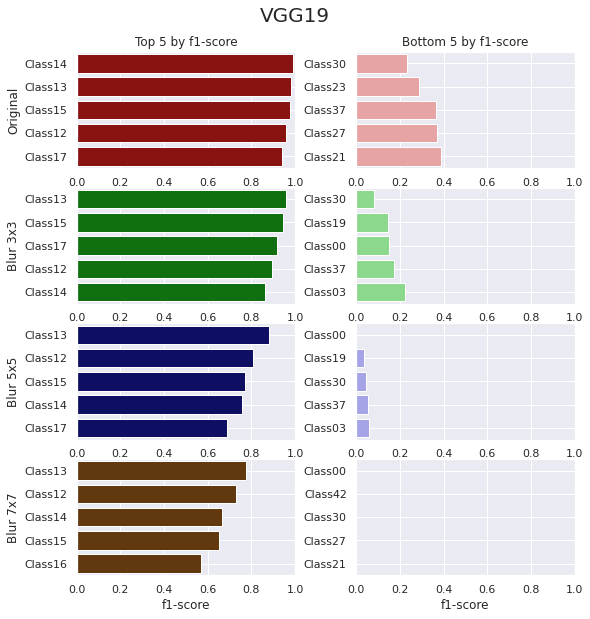

In [ ]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(8, 8))
sns.set_style('darkgrid')

sns.barplot(y = 'index', x = 'f1-score', data=vgg19_df_top, ax=ax[0,0], color='#9c0000')
ax[0,0].set_xlim([0, 1.0])
ax[0,0].set_ylabel('Original')
ax[0,0].set_title('Top 5 by f1-score')
ax[0,0].set_xlabel("")
ax[0,0].grid(True)

sns.barplot(y = 'index', x = 'f1-score', data=vgg19_df_bottom, ax=ax[0,1], color='#f29999')
ax[0,1].set_xlim([0, 1.0])
ax[0,1].set_title('Bottom 5 by f1-score')
ax[0,1].set_xlabel("")
ax[0,1].set_ylabel("")
ax[0,1].grid(True)

sns.barplot(y = 'index', x = 'f1-score', data=vgg19_df_top_3, ax=ax[1,0], color='#007F00')
ax[1,0].set_xlabel("")
ax[1,0].set_ylabel('Blur 3x3')
ax[1,0].set_xlim([0, 1.0])
ax[1,0].grid(True)

sns.barplot(y = 'index', x = 'f1-score', data=vgg19_df_bottom_3, ax=ax[1,1], color='#7fe57f')
ax[1,1].set_xlim([0, 1.0])
ax[1,1].set_xlabel("")
ax[1,1].set_ylabel("")
ax[1,1].grid(True)

sns.barplot(y = 'index', x = 'f1-score', data=vgg19_df_top_5, ax=ax[2,0], color='#000070')
ax[2,0].set_xlabel("")
ax[2,0].set_ylabel('Blur 5x5')
ax[2,0].set_xlim([0, 1.0])
ax[2,0].grid(True)

sns.barplot(y = 'index', x = 'f1-score', data=vgg19_df_bottom_5, ax=ax[2,1], color='#9999f2')
ax[2,1].set_xlim([0, 1.0])
ax[2,1].set_xlabel("")
ax[2,1].set_ylabel("")
ax[2,1].grid(True)

sns.barplot(y = 'index', x = 'f1-score', data=vgg19_df_top_7, ax=ax[3,0], color='#703800')
ax[3,0].set_ylabel('Blur 7x7')
ax[3,0].set_xlim([0, 1.0])
ax[3,0].grid(True)

sns.barplot(y = 'index', x = 'f1-score', data=vgg19_df_bottom_7, ax=ax[3,1], color='#f2c599')
ax[3,1].set_xlim([0, 1.0])
ax[3,1].set_ylabel("")
ax[3,1].grid(True)

fig.tight_layout(pad=0)
fig.suptitle('VGG19', position=(0.5, 1.05), fontsize=20)

fig.savefig(os.path.join(visualization_path, 'vgg19_f1_scores.png'), dpi=300, bbox_inches='tight')

## Visualizations of Comparison of Accuracy and Training Time

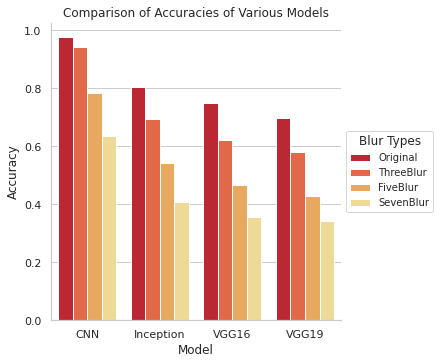

In [ ]:
# Comparison of Accuracies of all the models.

accuracy_df = pd.DataFrame(data=[{'Model':'CNN', 'Original':self_acc_original, 'ThreeBlur':self_acc_3, 'FiveBlur':self_acc_5, 'SevenBlur':self_acc_7},{'Model':'Inception', 'Original':inception_acc_original, 'ThreeBlur':inception_acc_3, 'FiveBlur':inception_acc_5, 'SevenBlur':inception_acc_7},{'Model':'VGG16', 'Original':vgg16_acc_original, 'ThreeBlur':vgg16_acc_3, 'FiveBlur':vgg16_acc_5, 'SevenBlur':vgg16_acc_7},{'Model':'VGG19', 'Original':vgg19_acc_original, 'ThreeBlur':vgg19_acc_3, 'FiveBlur':vgg19_acc_5, 'SevenBlur':vgg19_acc_7}])
accuracy_df = pd.melt(accuracy_df, id_vars="Model", var_name="Blurs", value_name="Accuracy")

sns.set_style('whitegrid')
sns.catplot(x='Model', y='Accuracy', hue='Blurs', data=accuracy_df, kind='bar', palette='YlOrRd_r', legend=False)
plt.legend(title='Blur Types', fontsize=10, loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Comparison of Accuracies of Various Models')

plt.savefig(os.path.join(visualization_path, 'accuracy_comparison.png'), dpi=300, bbox_inches='tight')

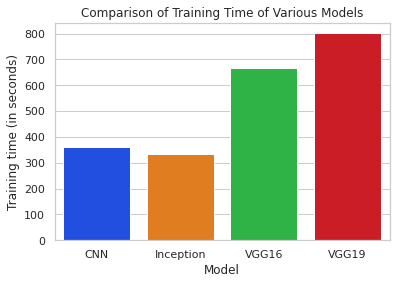

In [ ]:
# Comparison of Training time taken by each model.

sns.set_style('whitegrid')
models = ['CNN', 'Inception', 'VGG16', 'VGG19']
time_values = [self_training_time, inception_training_time, vgg16_training_time, vgg19_training_time]
sns.barplot(y=time_values, x=models, palette='bright')
plt.ylabel('Training time (in seconds)')
plt.xlabel('Model')
plt.title('Comparison of Training Time of Various Models')

plt.savefig(os.path.join(visualization_path, 'training_time_comparison.png'), dpi=300, bbox_inches='tight')

## Thank You 